In [80]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

In [81]:
# img_test = cv.imread('datasets/normal/nodefect(1).bmp')
img_test = cv.imread('datasets/unnormal/defection(3).bmp')
# plt.imshow(img_test)

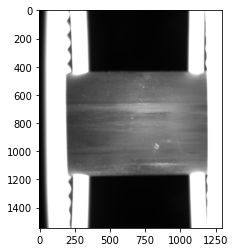

In [82]:
img_test_gray = cv.imread('datasets/unnormal/defection(1).bmp', cv.IMREAD_GRAYSCALE)
# img_test_gray = cv.imread('datasets/normal/nodefect(1).bmp', cv.IMREAD_GRAYSCALE)
plt.imshow(img_test_gray, cmap='gray')

In [83]:
# src_width, src_height, src_channels = img_test.shape
# print(src_width, src_height, src_channels)

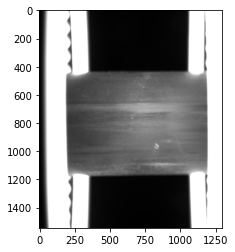

In [84]:
# we used median blurring
img_test_gray_median_blur = cv.medianBlur(img_test_gray, 7)
plt.imshow(img_test_gray_median_blur, cmap='gray')

'\n    by the hist we can find that most of the img is upper than 200\n    so we set the 200 to be the threshold to get our threshold img\n    and then we use canny to get the edge\n'

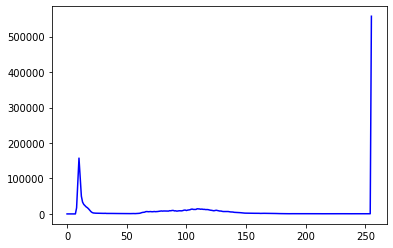

In [85]:
# config class
# hist to conclude the binary_threshold
img_hist = cv.calcHist([img_test_gray_median_blur], [0], None, [256], [0, 256])
plt.plot(img_hist, label='B', color='b')

'''
    by the hist we can find that most of the img is upper than 200
    so we set the 200 to be the threshold to get our threshold img
    and then we use canny to get the edge
'''

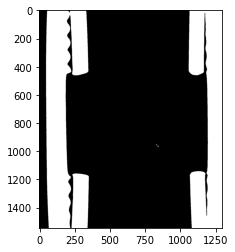

In [86]:
# transform into binary img and use threshold method
_, img_gray_blur_binary = cv.threshold(img_test_gray_median_blur, 200, 255, cv.THRESH_BINARY)
plt.imshow(img_gray_blur_binary, cmap='gray')

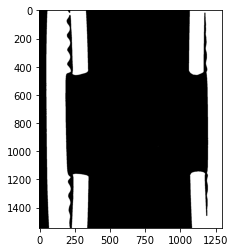

In [87]:
# we use canny method to find the borden
# but first we need to erosion the img for 2 times
img_gray_blur_binary_erode = cv.erode(img_gray_blur_binary, None, iterations=2)
plt.imshow(img_gray_blur_binary_erode, cmap='gray')

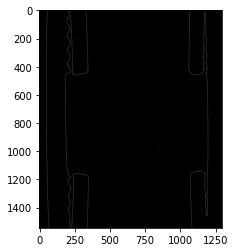

In [88]:
# after the erode we can now use canny method to find the edge
img_gray_blur_binary_erode_canny = cv.Canny(img_gray_blur_binary_erode, 0, 50, apertureSize=3 )
plt.imshow(img_gray_blur_binary_erode_canny, cmap='gray')


In [89]:
# then we get the img after canny and we print the borden
# now we try to get the contours and get the img in the contours

(contours, _) = cv.findContours(img_gray_blur_binary_erode_canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# print the number of contours
print('the count of contours is %d \n' % (len(contours)))


the count of contours is 6 



In [90]:
def sobel_h(img, threshold):
    '''
    edge detection with the horizon Sobel filter

    Parameters
    ----------
    img : TYPE
        the image input.
    threshold : TYPE
         varies for application [0 255].

    Returns
    -------
    mag : TYPE
        output after edge detection.

    '''
    G_y = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])
    rows = np.size(img, 0)
    columns = np.size(img, 1)
    mag = np.zeros(img.shape)
    for i in range(0, rows - 2):
        for j in range(0, columns - 2):
            h = sum(sum(G_y * img[i:i+3, j:j+3]))  # horizon
            mag[i+1, j+1] = h

    for p in range(0, rows):
        for q in range(0, columns):
            if mag[p, q] < threshold:
                mag[p, q] = 0
    return mag

# img_test_v = sobel_h(img_test_gray_median_blur, 200)
# plt.imshow(img_test_v, cmap='gray')


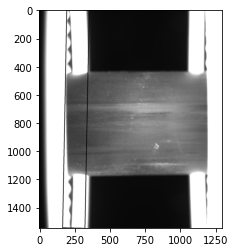

In [91]:
# area = []
# # 找到最大的轮廓
# for k in range(len(contours)):
#     area.append(cv.contourArea(contours[k]))
# max_idx = np.argmin(np.array(area))
#     # cv2.fillContexPoly(mask[i], contours[max_idx], 0)
#     # 填充最大的轮廓
# # cv.drawContours(mask[i], contours, max_idx, 0, cv2.FILLED)

# print(max_idx)

c = sorted(contours, key=cv.contourArea, reverse=True)[0]

rect = cv.minAreaRect(c)
box = np.int0(cv.boxPoints(rect))

img_copy = img_test_gray.copy()
draw_img = cv.drawContours(img_copy, [box], -1, (0, 0, 255), 3)


# img_copy = img_test_gray.copy()
# cv.drawContours(img_copy, contours, -1, (120, 120, 120), 40)
plt.imshow(img_copy, cmap='gray')

In [92]:
# first we define some function:
'''
对坐标点进行排序
@return     [top-left, top-right, bottom-right, bottom-left]
'''
class Config:
    def __init__(self):
        pass
    src = None
    resizeRate = 0.5
    min_area = 5000
    min_contours = 8
    threshold_thresh = 50
    epsilon_start = 10
    epsilon_step = 10


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


# 求两点间的距离
def point_distance(a,b):
    return int(np.sqrt(np.sum(np.square(a - b))))


# 找出外接四边形, c是轮廓的坐标数组
def bounding_box(idx,c):
    if len(c) < Config.min_contours:
        return None
    epsilon = Config.epsilon_start
    while True:
        approx_box = cv.approxPolyDP(c,epsilon,True)
        #求出拟合得到的多边形的面积
        the_area = math.fabs(cv.contourArea(approx_box))
        #输出拟合信息
        print("contour idx: %d ,contour_len: %d ,epsilon: %d ,approx_len: %d ,approx_area: %s"%(idx,len(c),epsilon,len(approx_box),the_area))
        if len(approx_box) < 4:
            return None
        if the_area > Config.min_area:
            if len(approx_box) > 4:
                # epsilon 增长一个步长值
                epsilon += Config.epsilon_step
                continue
            else: #approx的长度为4，表明已经拟合成矩形了
                #转换成4*2的数组
                approx_box = approx_box.reshape((4, 2))
                return approx_box
        else:
            print("failed to find boundingBox,idx = %d area=%f"%(idx, the_area))
            return None


# for idx, c in enumerate(contours):
#     approx_box = bounding_box(idx,c)
#     if approx_box is None:
#         print("\n")
#         continue
#
#     # 获取最小矩形包络
#     rect = cv.minAreaRect(approx_box)
#     box = cv.boxPoints(rect)
#     box = np.int0(box)
#     box = box.reshape(4,2)
#     box = order_points(box)
#     print("boundingBox：\n",box)
#
#     # 待切割区域的原始位置，
#     # approxPolygon 点重排序, [top-left, top-right, bottom-right, bottom-left]
#     src_rect = order_points(approx_box)
#     print("src_rect：\n",src_rect)
#
#     w,h = point_distance(box[0],box[1]), point_distance(box[1],box[2])
#     print("w = %d ,h= %d "%(w,h))
#
#     # 生成透视变换矩阵
#     dst_rect = np.array([
#         [0, 0],
#         [w - 1, 0],
#         [w - 1, h - 1],
#         [0, h - 1]],
#         dtype="float32")
#
#     # 透视变换
#     M = cv.getPerspectiveTransform(src_rect, dst_rect)
#
#     #得到透视变换后的图像
#     warped = cv.warpPerspective(img_test_gray, M, (w, h))
#
#     #将变换后的结果图像写入png文件
#     # cv.imwrite("output/piece%d.png"%idx, warped, [int(cv.IMWRITE_PNG_COMPRESSION), 9])
#     plt.imshow(warped, cmap='gray')
#     plt.show()
#     print("\n")


